In [155]:
#| echo: false
#| output: false
#| warning: false


import tomlkit
import scanpy as sc
import anndata as ad

import numpy as np
import pandas as pd
import itables

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc_context
import patchworklib as pw
import seaborn.objects as so
import hvplot
import hvplot.pandas

from typing import List, Dict

from IPython.display import display
from os import walk, path, mkdir, listdir, cpu_count
import session_info
import logging
from utils.preprocessing_funcs import *

logging.basicConfig(level=logging.ERROR)
sc.set_figure_params(dpi = 100, dpi_save = 300, format= "png")
sc.settings.n_jobs = int(cpu_count() * 0.8)


In [156]:
#| echo: true
#| output: false
#| warning: false


"in the following cell, override the default pipeline parameters if needed"

#QC Params
CONCAT_SAMPLES: bool = True         # Concatenate all samples in one object, default: true
CORRECT_AMBIENT_RNA: bool = True   # Correct ambient RNA, uses DecontX, Currently causes multiple erros.
FILTER_DOUBLETS: bool = True       # Filter doublets using Scrublet
CELL_CYCLE_SCORE: bool = True       # Calculate cell cycle scores, based on scanpy implementation.
REGRESS: bool = False               # Regress out unwanted variables. Not recommended.
VARS_TO_REGRESS: List[str] = []     # list of regress (pct_counts_mt, pct_counts_ribo).


############################################################
####################     QC Dict      ######################
############################################################

"""
Can either be a flat-dict for global threshold or a dict of dicts for each sample 
Entries in the form of col_name: [low, high] Ex: 'pct_counts_mt':[0, 20] which will be used as (low, high) pair.
Also entries can be a single number Ex: 'pct_counts_mt': 3 which be used as number of MADS as follows media -+ nmad * MAD. 
"""

# by default, filtering on read counts, number of features, and mitochondrial content
qc_dict: Dict[str, List] | Dict[str, Number] = {
    "n_genes_by_counts": 5,
    "total_counts": 5,
    "pct_counts_mt":5,
}

# MODIFY_ME, Specifiy only after running diagnotics on the samples
# global config
# qc_dict: Dict[str, List] | Dict[str, List] = {
#     "pct_counts_mt": [0, 10],
#     "pct_counts_rb": [0, 10],
#     "n_genes_by_counts": [1500, 9000],
#     "total_counts": [3_000, 40_000]
# }


# # per-sample config
# qc_dict: Dict[str, List] | Dict[str, List] = {
#     "sample1": {
#         "pct_counts_mt": [0, 10],
#         "pct_counts_rb": [0, 10],
#         "total_counts": [3_000, 40_000]
#     },
#     "sample2": {
#         "pct_counts_rb": [0, 10],
#         "n_genes_by_counts": [1500, 9000],
#         "total_counts": [3_000, 40_000]
#     },
#     "sample3": {
#         "pct_counts_mt": [0, 10],
#         "n_genes_by_counts": [1500, 9000],
#         "total_counts": [3_000, 40_000]
#     },
#     "sample4": {
#         "pct_counts_mt": [0, 10],
#         "pct_counts_rb": [0, 10],
#         "n_genes_by_counts": [1500, 9000],
#     }
# }

In [157]:
#| echo: false 
#| output: false
#| warning: false

## Pipeline parameters
with open("../config.toml", "r") as f:
    config = tomlkit.parse(f.read())


In [158]:
#| echo: false 
#| output: false
#| warning: false


#Directories 
ROOT_DIR = config["basic"]["ANALYSIS_DIR"]
DIR_SAVE = path.join(ROOT_DIR, config["basic"]["DIR_SAVE"])
DIR_samples = config["basic"]["DIR_SAMPLES"]

#Basic information
TECHNOLOGY: str = config["basic"]["TECHNOLOGY"]
ORGANISM: str = config["basic"]["ORGANISM"]
AUTODISCOVER: bool = config["basic"]["auto_find"]
samples: Dict[str, str] = config["basic"]["samples"]

sample_components = inputs[TECHNOLOGY]["files"]
black_list = inputs[TECHNOLOGY]["black_list"]
read_function = inputs[TECHNOLOGY]["function"]
raw_name = inputs[TECHNOLOGY]["raw_name"]

In [159]:
#| echo: false 
#| output: false
#| warning: false

# Keys

keys = get_keys(qc_dict)

if len(get_keys(qc_dict)) == 0:
    raise ValueError("Couldn't get valid qc variables from QC dict.")

prior_keys = keys

keys = keys + ["pct_counts_rb"]

if FILTER_DOUBLETS:
    keys = keys + ["doublet_score"]

if CELL_CYCLE_SCORE:
    keys = keys + ["S_score", "G2M_score"]

# Remove Duplicates
keys = list(set(keys))

In [160]:
#| echo: false 
#| warning: false


# Diagnosic pipeline
## Reading files

if AUTODISCOVER and len(samples) == 0:
    files = walk(DIR_samples)
    for root, dir, files in files:
        if len(set(sample_components).difference(set(files))) == 0 and path.basename(root) != raw_name:
            samples[get_sample_name(root, black_list, 5)] = root
else:
    samples = config["basic"]["samples"]
    if len(samples) > 0:
        pass
    else:
        raise RuntimeError("No samples paths were provided, provide sample paths as a dictionary in 'config.toml'")

# Samples

In [161]:
#| warning: false
itables.show(pd.DataFrame(samples,  index = ["sample path"]).T)

In [162]:
#| echo: false 
#| output: false
#| warning: false

adatas = {}
raw_h5 = {}
for sample_id, filename in samples.items():
    sample_adata = read_function(filename)
    sample_adata.var_names_make_unique()
    adatas[sample_id] = sample_adata


if TECHNOLOGY == "10x" and CORRECT_AMBIENT_RNA:
    for sample_id, filename in samples.items():
        files = listdir(path.dirname(filename))
        raw_file = [file for file in files if "raw_feature_bc_matrix" in file and ".h5" in file]
        if len(raw_file) == 1:
            adata_raw = sc.read_10x_h5(path.join(path.dirname(filename), raw_file[0]))
        else:
            raise ValueError("No/Multiple raw files meeting condition were found")

        adata_raw.var_names_make_unique()
        raw_h5[sample_id] = adata_raw


if CONCAT_SAMPLES:
    adata = ad.concat(adatas, label="sample", join="outer", merge="same")
    adata.obs_names_make_unique()
    del samples

if CONCAT_SAMPLES and TECHNOLOGY == "10x" and CORRECT_AMBIENT_RNA:
    adata_raw = ad.concat(raw_h5, label="sample", join="outer", merge="same")
    adata_raw.obs_names_make_unique()
    del raw_h5


In [163]:
#| echo: false 
#| output: false
#| warning: false

## Adding quality metrics
mt_features = qc_features_fac[ORGANISM]["mito"]
rb_features = qc_features_fac[ORGANISM]["ribo"]
hb_features = qc_features_fac[ORGANISM]["hb"]


# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith(tuple(mt_features))
# ribosomal genes
adata.var["rb"] = adata.var_names.str.startswith(tuple(rb_features))
# hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains(tuple(hb_features)[0]) #Only regex is accepted

sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "rb", "hb"], percent_top=[20],  inplace=True, log1p=True
)


In [164]:
#| echo: false 
#| output: false
#| warning: false

if all(map(lambda x: isinstance(x, (list, Number)), qc_dict.values())):
        reduce_outliers(adata, qc_dict)
elif all(map(lambda x: isinstance(x, dict), qc_dict.values())):
        reduce_outliers(adata, qc_dict, subset= True)
else:
        raise ValueError("Please provide a QC-Dict in a valid format.")
        


In [165]:
#| echo: false 
#| output: false
#| warning: false


## Ambient RNA correction
## TODO: Check if the Ambient RNA can be improved by using Batch information?

if CORRECT_AMBIENT_RNA and TECHNOLOGY == "10x":

    from os import system, remove, path
    import tempfile
    import urllib.request

    with tempfile.TemporaryDirectory(dir=".") as tmpdirname:

        # Workaround failure to install GenomeInfoDbData using pixi
        dn_path = path.join(tmpdirname, "GenomeInfoDbData_1.2.11.tar.gz")
        dn_url = "https://bioconductor.org/packages/3.18/data/annotation/src/contrib/GenomeInfoDbData_1.2.11.tar.gz"
        urllib.request.urlretrieve(dn_url, filename=dn_path)
        system(f"R CMD INSTALL {dn_path}")

        # Define paths for temporary files
        sce_path = path.join(tmpdirname, "sce.h5ad")
        raw_path = path.join(tmpdirname, "raw.h5ad")
        decontx_path = path.join(tmpdirname, "decontX.h5ad")
        
        # Save adata and adata_raw to the temporary directory
        adata.write_h5ad(sce_path)
        adata_raw.write_h5ad(raw_path)
        
        # Execute R scripts with temporary file paths
        system(f"Rscript ./utils/deconx.R -s {sce_path} -r {raw_path} -o {decontx_path}")

        # Read the result back from the temporary directory
        adata = sc.read_h5ad(decontx_path)

In [166]:
#| echo: false 
#| output: false
#| warning: false

## Doublet Detection

#TODO: Check real-life performance
#TODO: Check Interop with R to convert object to R & vice-versa 
if FILTER_DOUBLETS and TECHNOLOGY == "10x":
    sc.pp.scrublet(adata, batch_key="sample")

In [167]:
#| echo: false 
#| output: false
#| warning: false

## Cell cycle Scoring
# **Not reliable, do via interop later**

adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.scale(adata)


if CELL_CYCLE_SCORE:
    if ORGANISM in ["human", "mouse"]:

        s_genes = [x.strip() for x in open('../resources/s_genes.txt')]
        g2m_genes = [x.strip() for x in open('../resources/s_genes.txt')]

        if ORGANISM == "mouse":
            s_genes = human2mouse(s_genes)
            g2m_genes = human2mouse(g2m_genes)


        # Cell cycle scoring is not reliable and not similair to Seurat
        sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)
    else:
        logging.error('Organism must be either human or mouse.')

# Diagnostic Plots

## Basic QC plots & metrics

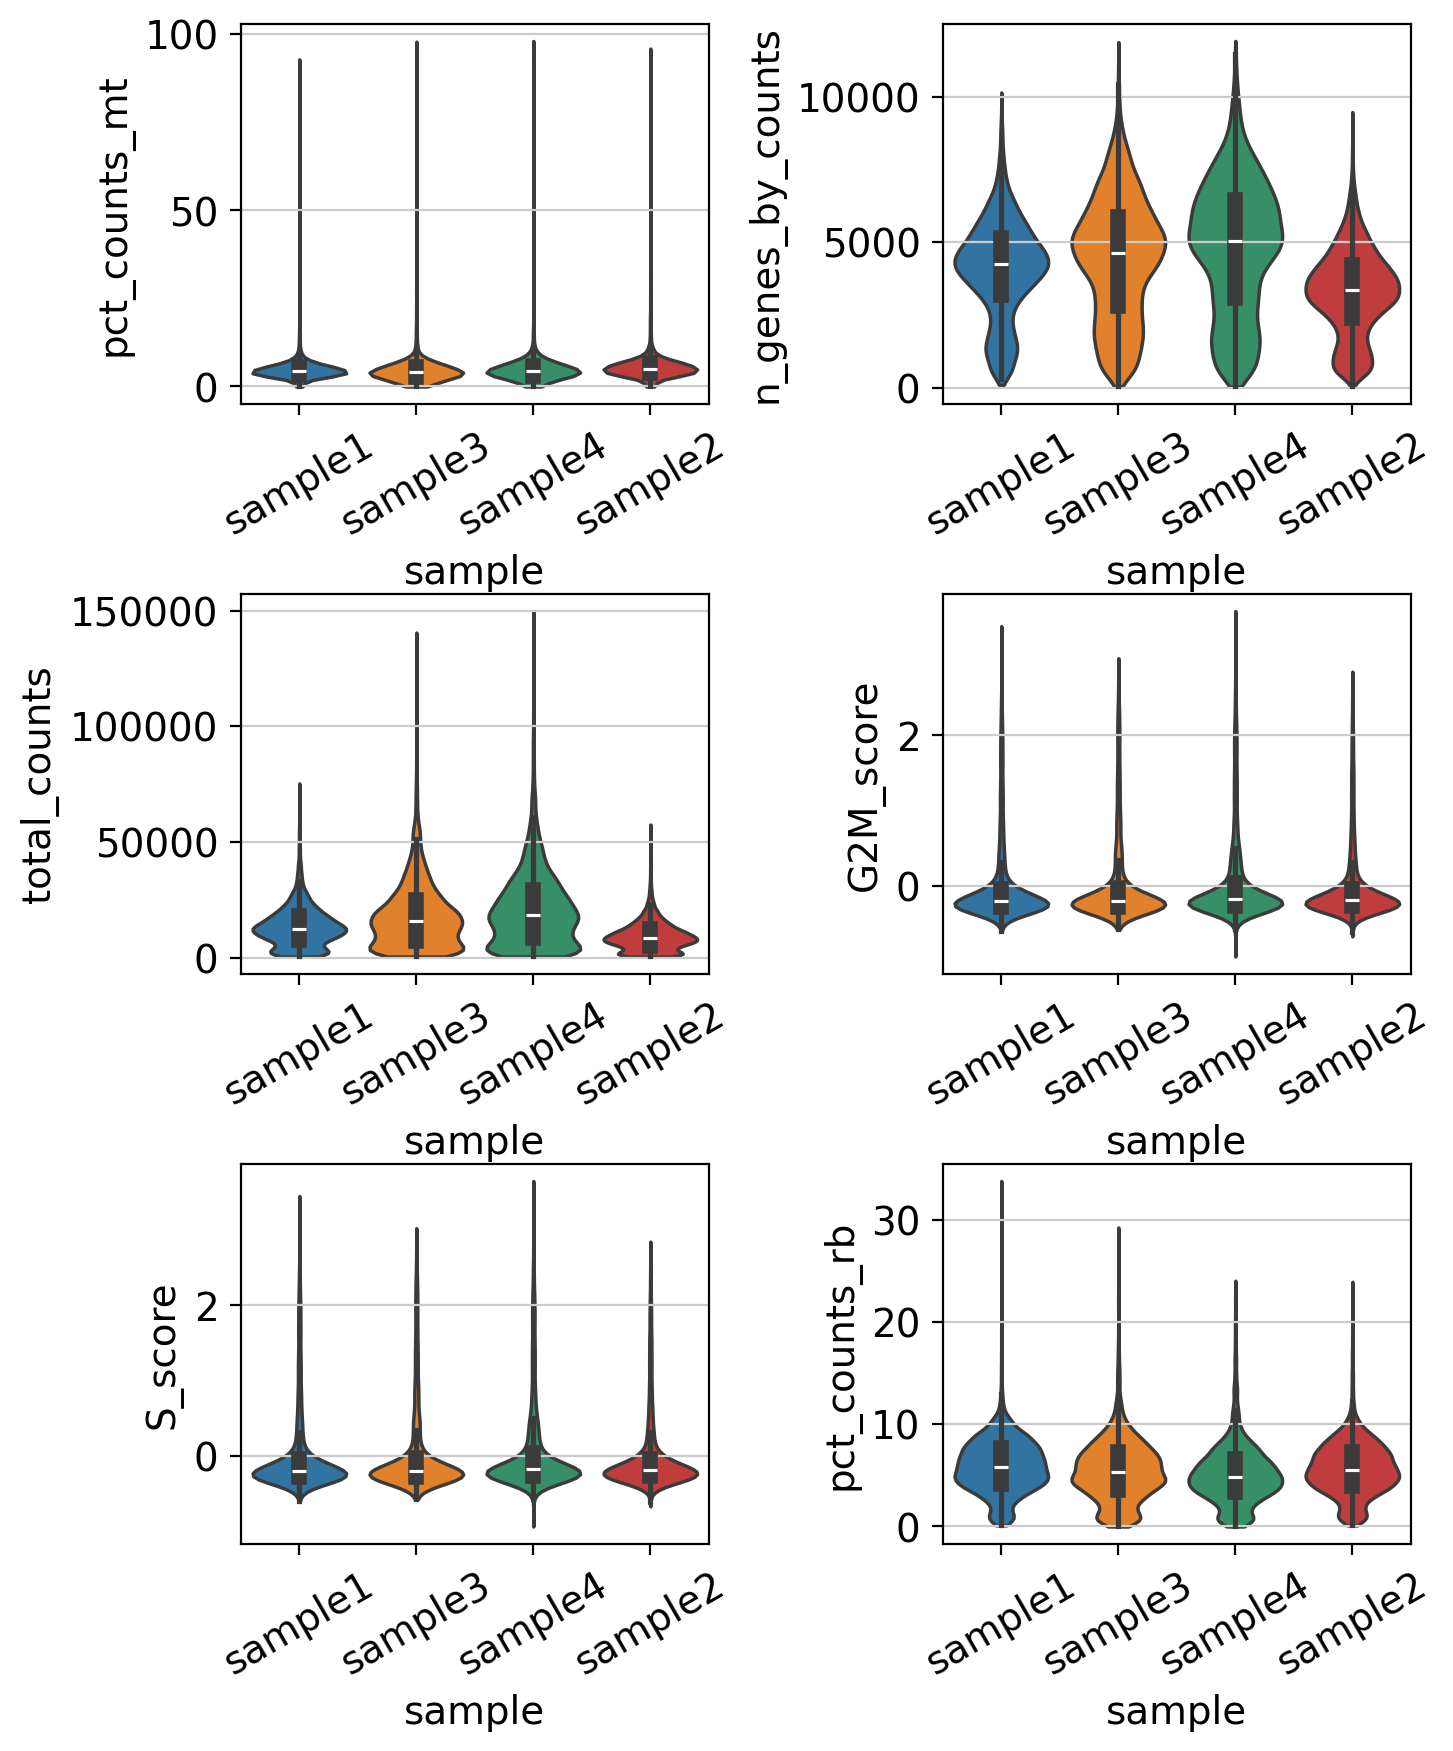

<Figure size 400x400 with 0 Axes>

In [168]:

ncols = 2
nrows = len(keys) // ncols + len(keys) % ncols

figsize = 3
wspace = 0.5
hspace = 0.5
fig, axs = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(ncols * figsize + figsize * wspace * (ncols - 1), nrows * figsize + hspace * (nrows - 1) ),
)
plt.subplots_adjust(wspace=wspace, hspace=hspace)

axs = axs.flatten()

# Prevent the subplots from showing 
plt.close(fig)


for i, key in enumerate(keys):
    sc.pl.violin(adata, keys=[key], groupby="sample", stripplot=False, inner="box", ax=axs[i])
    axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=30)

plt.tight_layout()
display(fig)


## Table of basic QC metrics

In [169]:
df1 = adata.obs.groupby("sample")[keys].agg(["mean", "median"]).round(3)
df2 = adata.obs.groupby("sample")[["sample"]].agg(["size"])
itables.show(pd.concat([df1, df2], axis =1))

## Histograms

### Interactive

In [170]:
#| echo: false 
#| warning: false


from operator import add

hvplot.extension("bokeh")
ls = []
df = adata.obs[keys]
for key in df.columns:
    fig = df[key].hvplot(kind = "hist", bins = 300, color = "#A3D5FF", width = 400, line_color = "#A3D5FF", bgcolor = "white").opts(axiswise=True)
    ls.append(fig)

layout = reduce(add, ls)
layout.cols(2)

:Layout
   .Histogram.I   :Histogram   [pct_counts_mt]   (Count)
   .Histogram.II  :Histogram   [n_genes_by_counts]   (Count)
   .Histogram.III :Histogram   [total_counts]   (Count)
   .Histogram.IV  :Histogram   [G2M_score]   (Count)
   .Histogram.V   :Histogram   [S_score]   (Count)
   .Histogram.VI  :Histogram   [pct_counts_rb]   (Count)

### Static

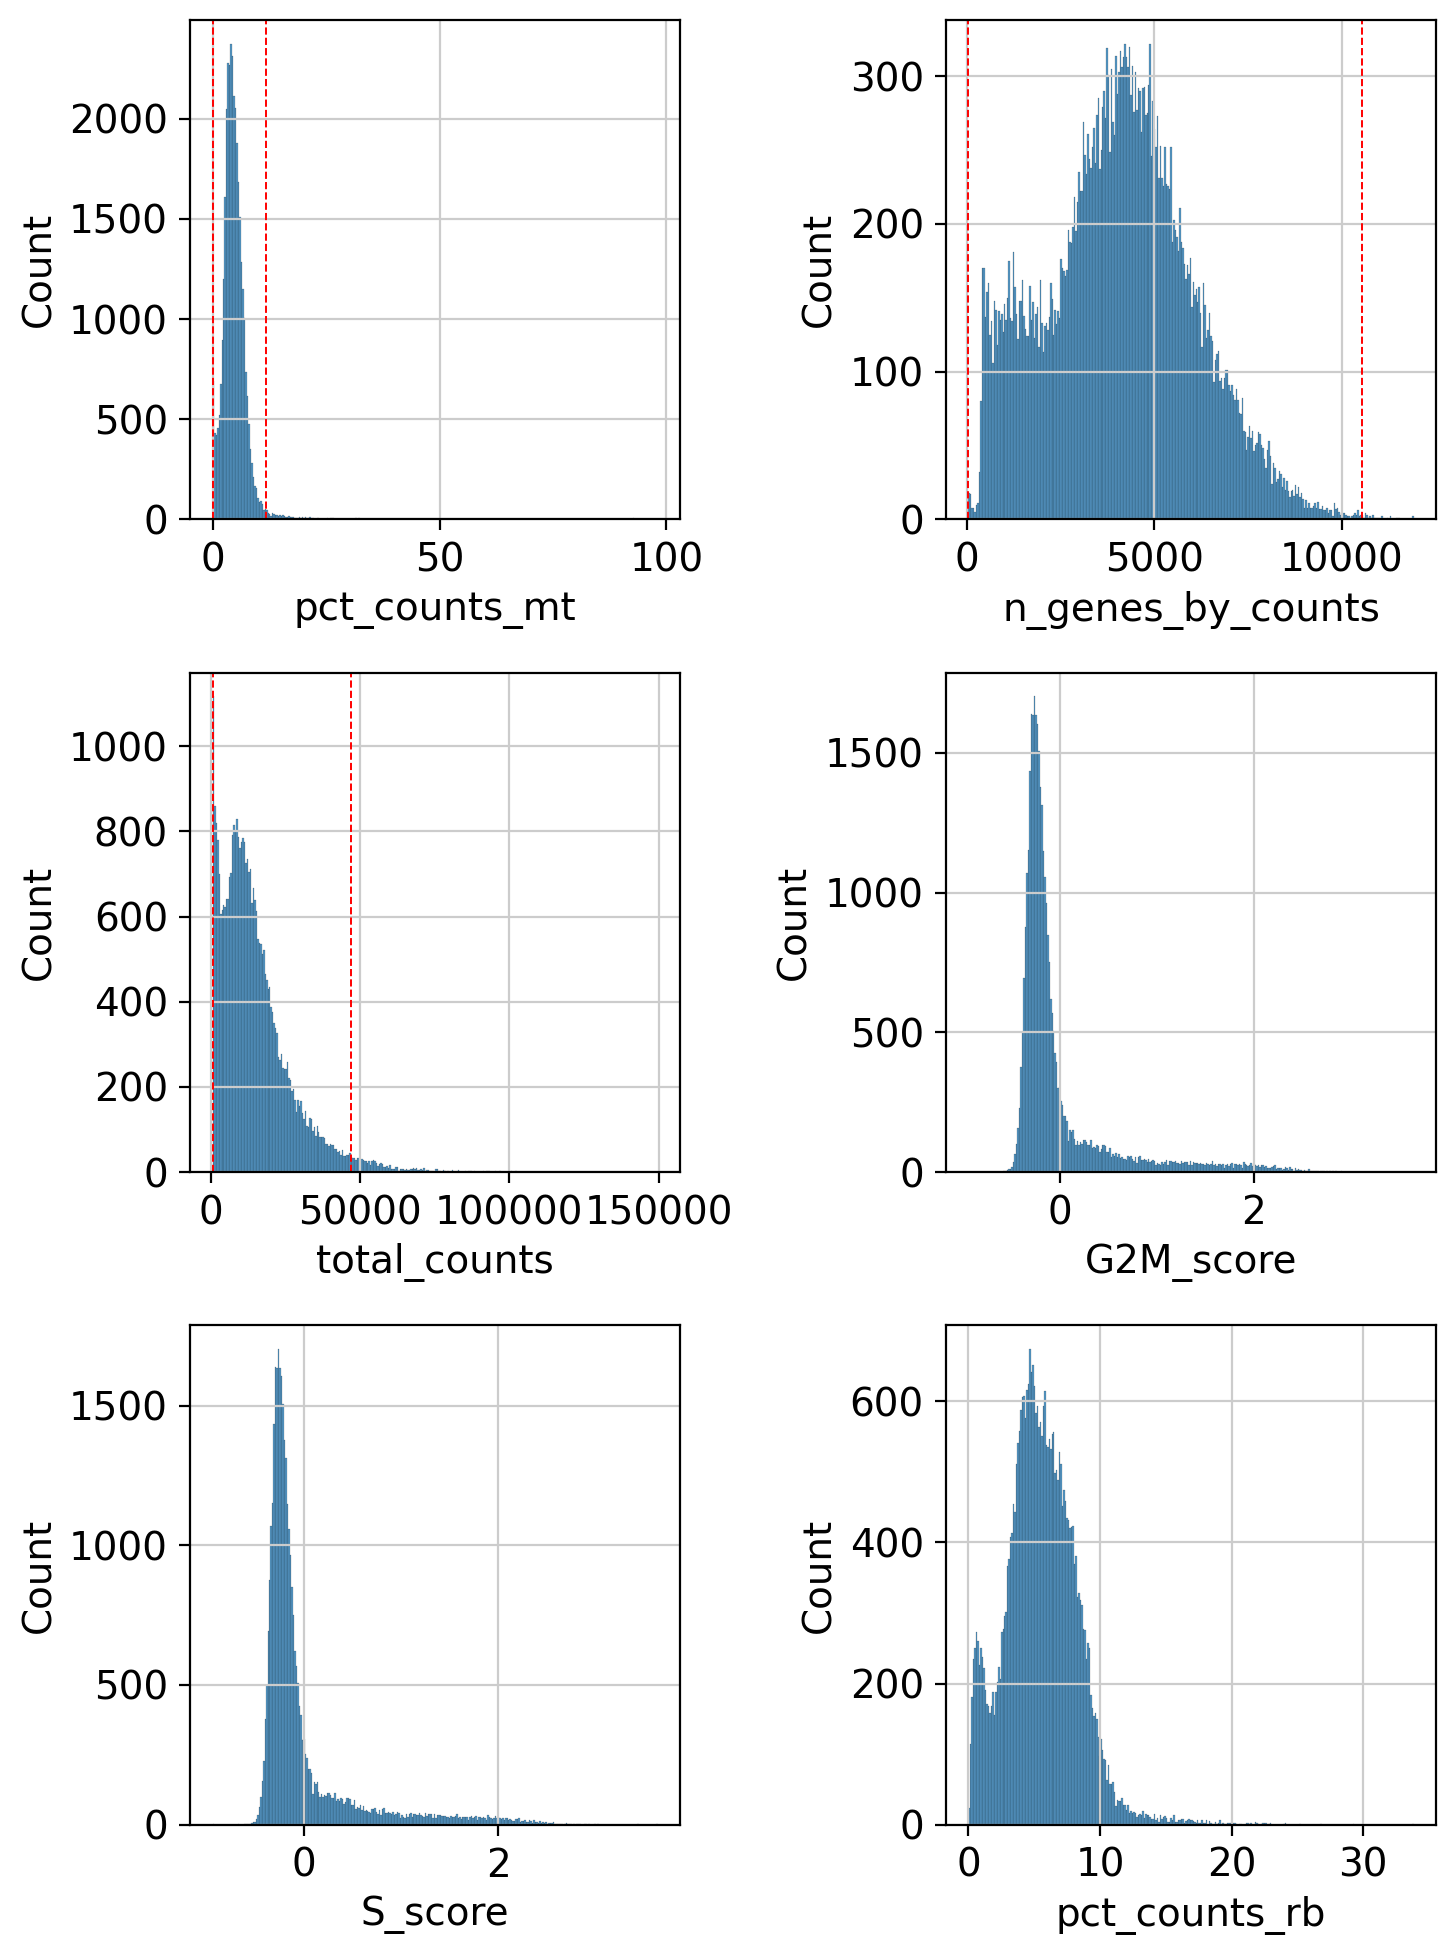

In [171]:
#| echo: false 
#| warning: false

# Wrong Impelementation
# TODO: FIX based on QC_Dict

n = len(keys)
ncols = 2
nrows = n // ncols + (n % ncols > 0)

# Create the subplots
wspace = 0.5
fig, axs = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(ncols * figsize + figsize * wspace * (ncols - 1), nrows * figsize + wspace * (nrows - 1) ),
)

plt.subplots_adjust(wspace=wspace, hspace=wspace)

# Flatten the axes
axs = axs.flatten()
outlier_dict = {}


# Plot a histogram on each subplot
for i, col in enumerate(keys):
    sns.histplot(data=df, x=col, ax=axs[i], bins=300)

    if col in ["n_genes_by_counts", "total_counts"]:
        max_line = min(df[col].agg("mean")+ median_abs_deviation(df[col]) * qc_dict["n_genes_by_counts"],  df[col].agg("max")) 
        min_line = max(df[col].agg("mean") - median_abs_deviation(df[col]) * qc_dict["total_counts"], df[col].agg("min"))
        axs[i].axvline(x=max_line, color='red', linestyle='--', linewidth = 0.7)
        axs[i].axvline(x=min_line, color='red', linestyle='--', linewidth = 0.7)


    elif col in ["pct_counts_mt"]:
        max_line = min(df[col].agg("mean")+ median_abs_deviation(df[col]) * qc_dict["total_counts"],  df[col].agg("max")) 
        min_line = max(df[col].agg("mean") - median_abs_deviation(df[col]) * qc_dict["total_counts"], df[col].agg("min"))
        axs[i].axvline(x=max_line, color='red', linestyle='--', linewidth = 0.7)
        axs[i].axvline(x=min_line, color='red', linestyle='--', linewidth = 0.7)


# Remove any unused subplots
if len(df.columns) < nrows*ncols:
    for i in range(len(df.columns), nrows*ncols):
        fig.delaxes(axs[i])

plt.tight_layout()
plt.show()

## Scatter plots of confounders

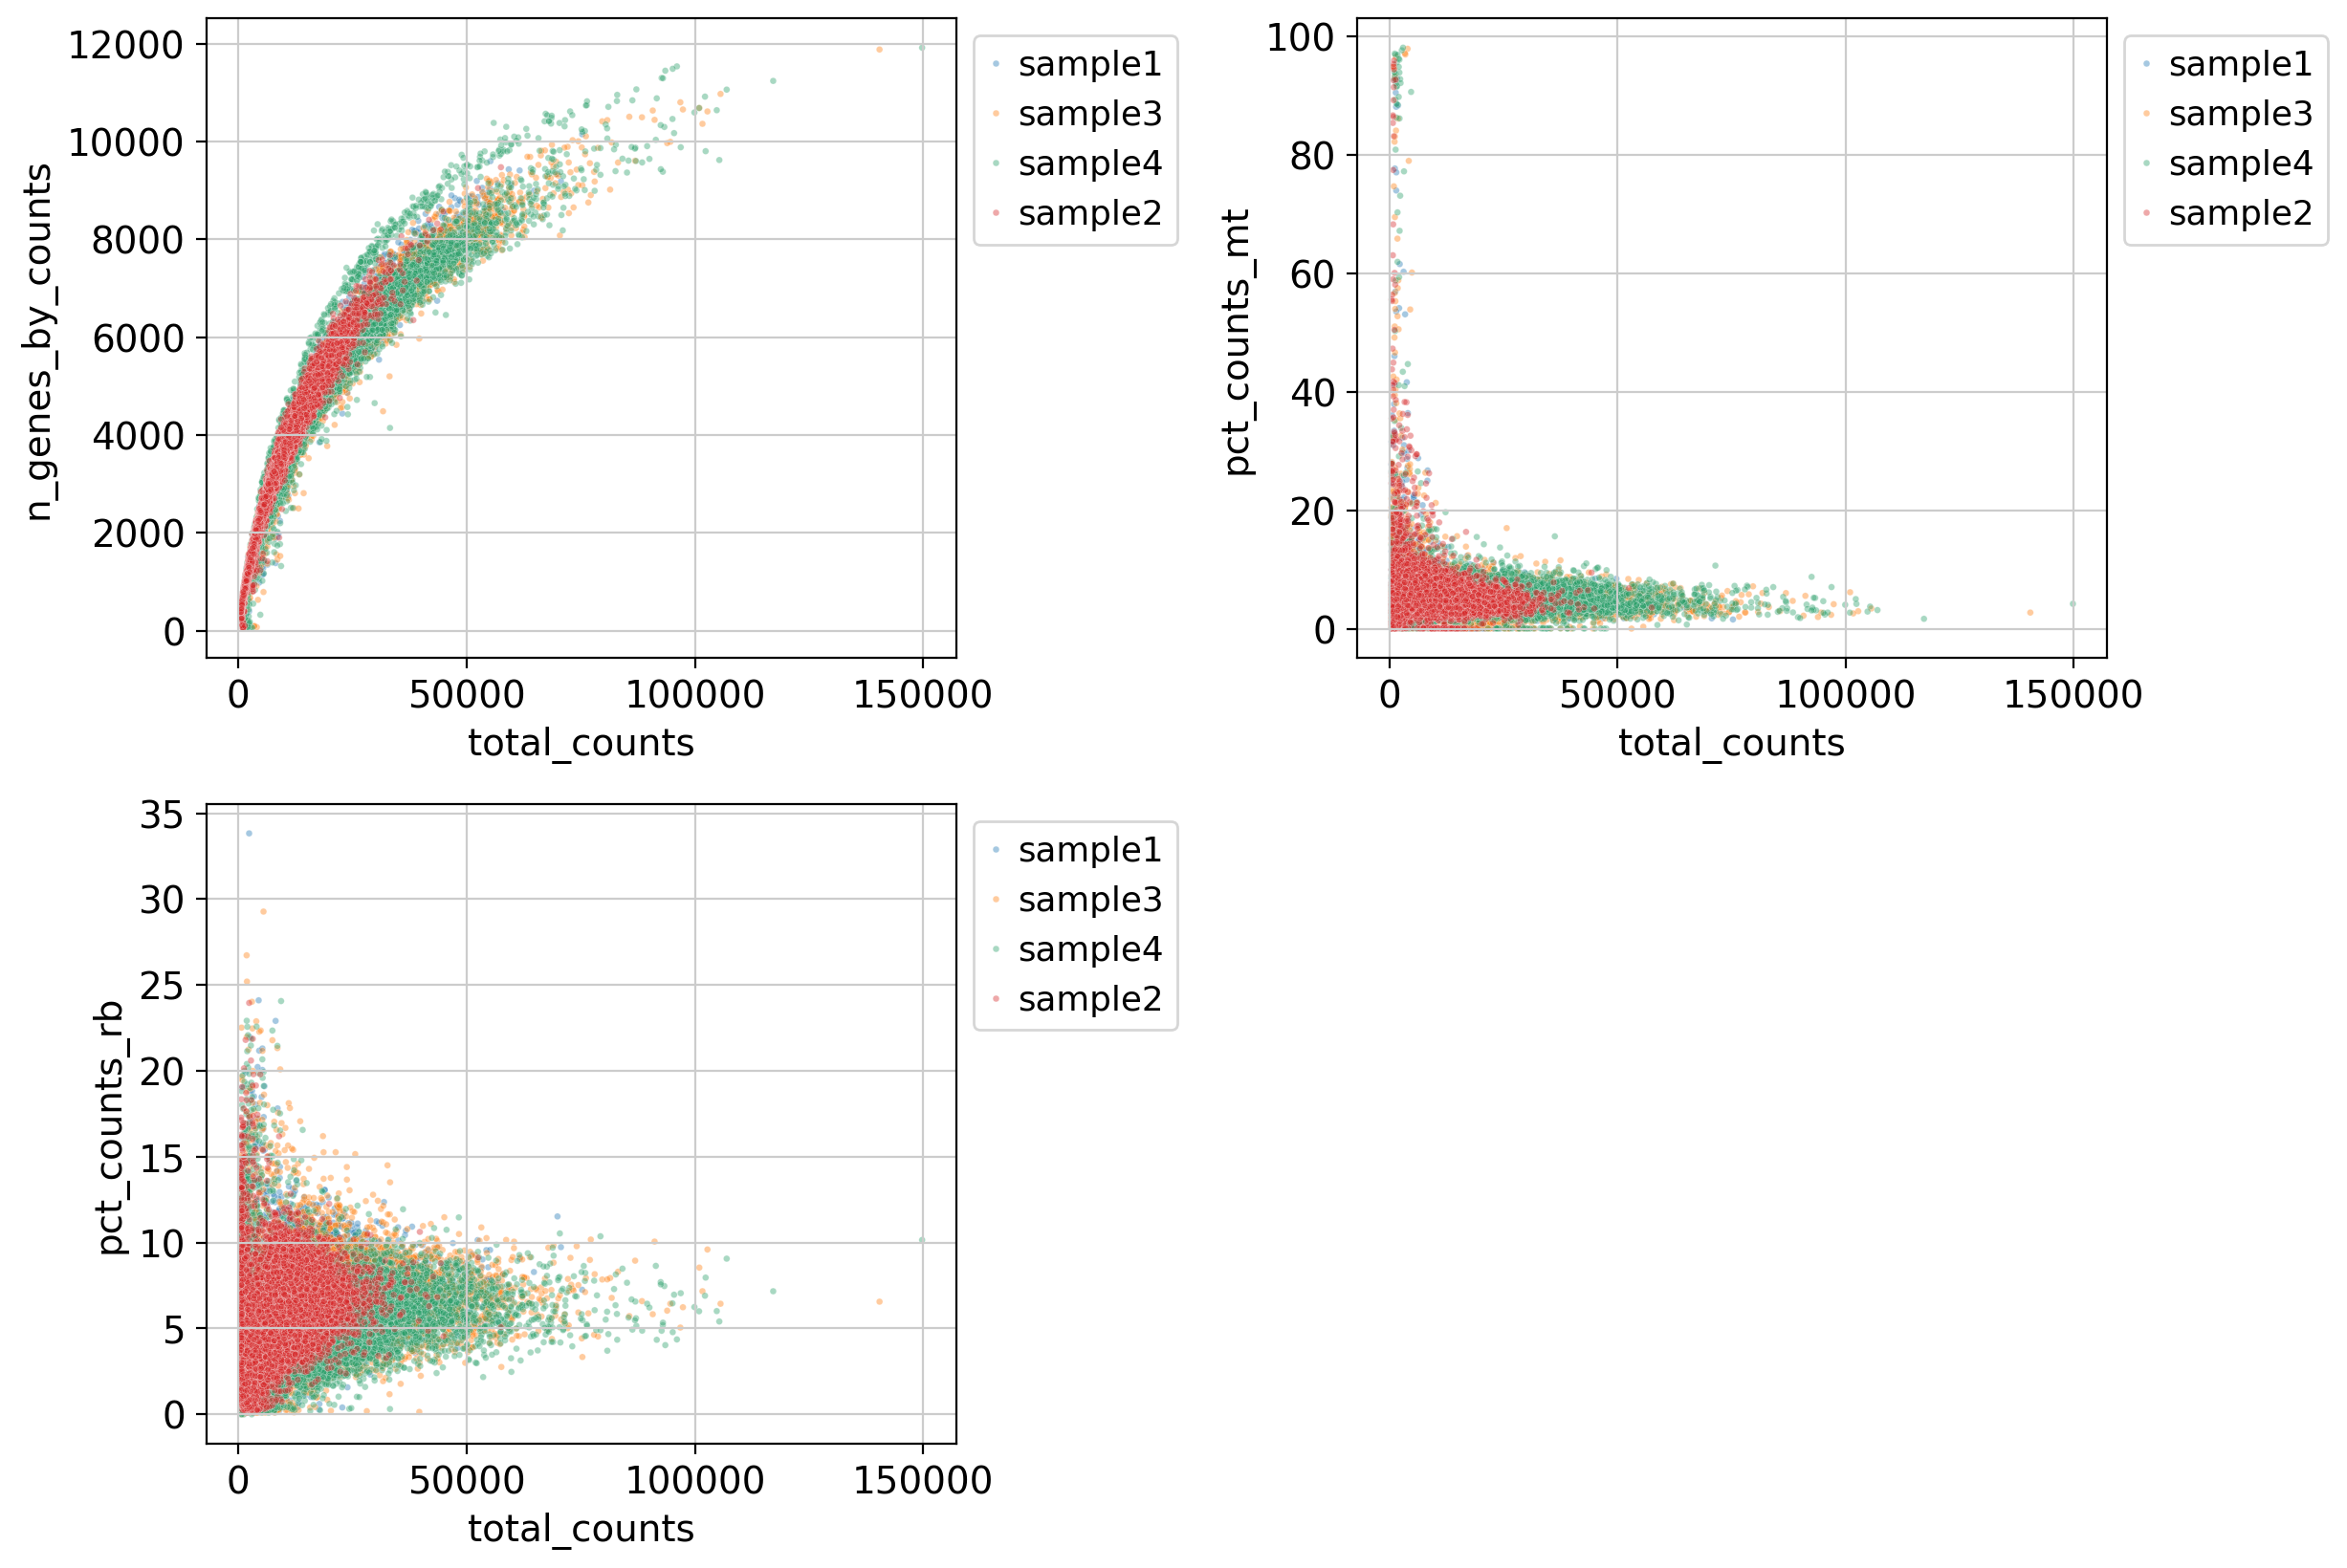

In [172]:
#| echo: false 
#| warning: false

# Assuming 'df' is your DataFrame
df = adata.obs[keys+["sample"]]

# Determine the number of rows and columns for your subplot grid
n = len(df.columns)
ncols = 2
nrows = 2
figwidth= 5
figheight = 4

# Create the subplots
wspace = 0.5
fig, axs = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(ncols * figwidth + figwidth * wspace * (ncols - 1), nrows * figheight + wspace * (nrows - 1) ),
)

plt.subplots_adjust(wspace=wspace, hspace=wspace)

# Flatten the axes
axs = axs.flatten()

sns.scatterplot(df, x="total_counts", y="n_genes_by_counts", hue = "sample", alpha = 0.4, s = 6,  ax= axs[0])
axs[0].legend(fancybox = True, framealpha = 0.8)
sns.scatterplot(df, x="total_counts", y="pct_counts_mt", hue = "sample", alpha = 0.4, s = 6,  ax= axs[1])
axs[1].legend(fancybox = True, framealpha = 0.8)
sns.scatterplot(df, x="total_counts", y="pct_counts_rb", hue = "sample", alpha = 0.4, s = 6,  ax= axs[2])
axs[2].legend(fancybox = True, framealpha = 0.8)
sns.move_legend(axs[0], "upper left", bbox_to_anchor=(1, 1))
sns.move_legend(axs[1], "upper left", bbox_to_anchor=(1, 1))
sns.move_legend(axs[2], "upper left", bbox_to_anchor=(1, 1))

if FILTER_DOUBLETS:
    sns.scatterplot(df, x="total_counts", y="doublet_score", hue = "sample", alpha = 0.4, s = 6,  ax= axs[3])

[fig.delaxes(ax) for ax in axs.flatten() if not ax.has_data()]


plt.tight_layout()
plt.show()


## Effects of confounders on dimensional reduction (prior to filtering)

In [173]:
#| echo: false 
#| output: false
#| warning: false

sc.pp.pca(adata, n_comps=30)
sc.pp.neighbors(adata)
sc.tl.leiden(adata, key_added="groups", flavor="leidenalg")
sc.tl.umap(adata)

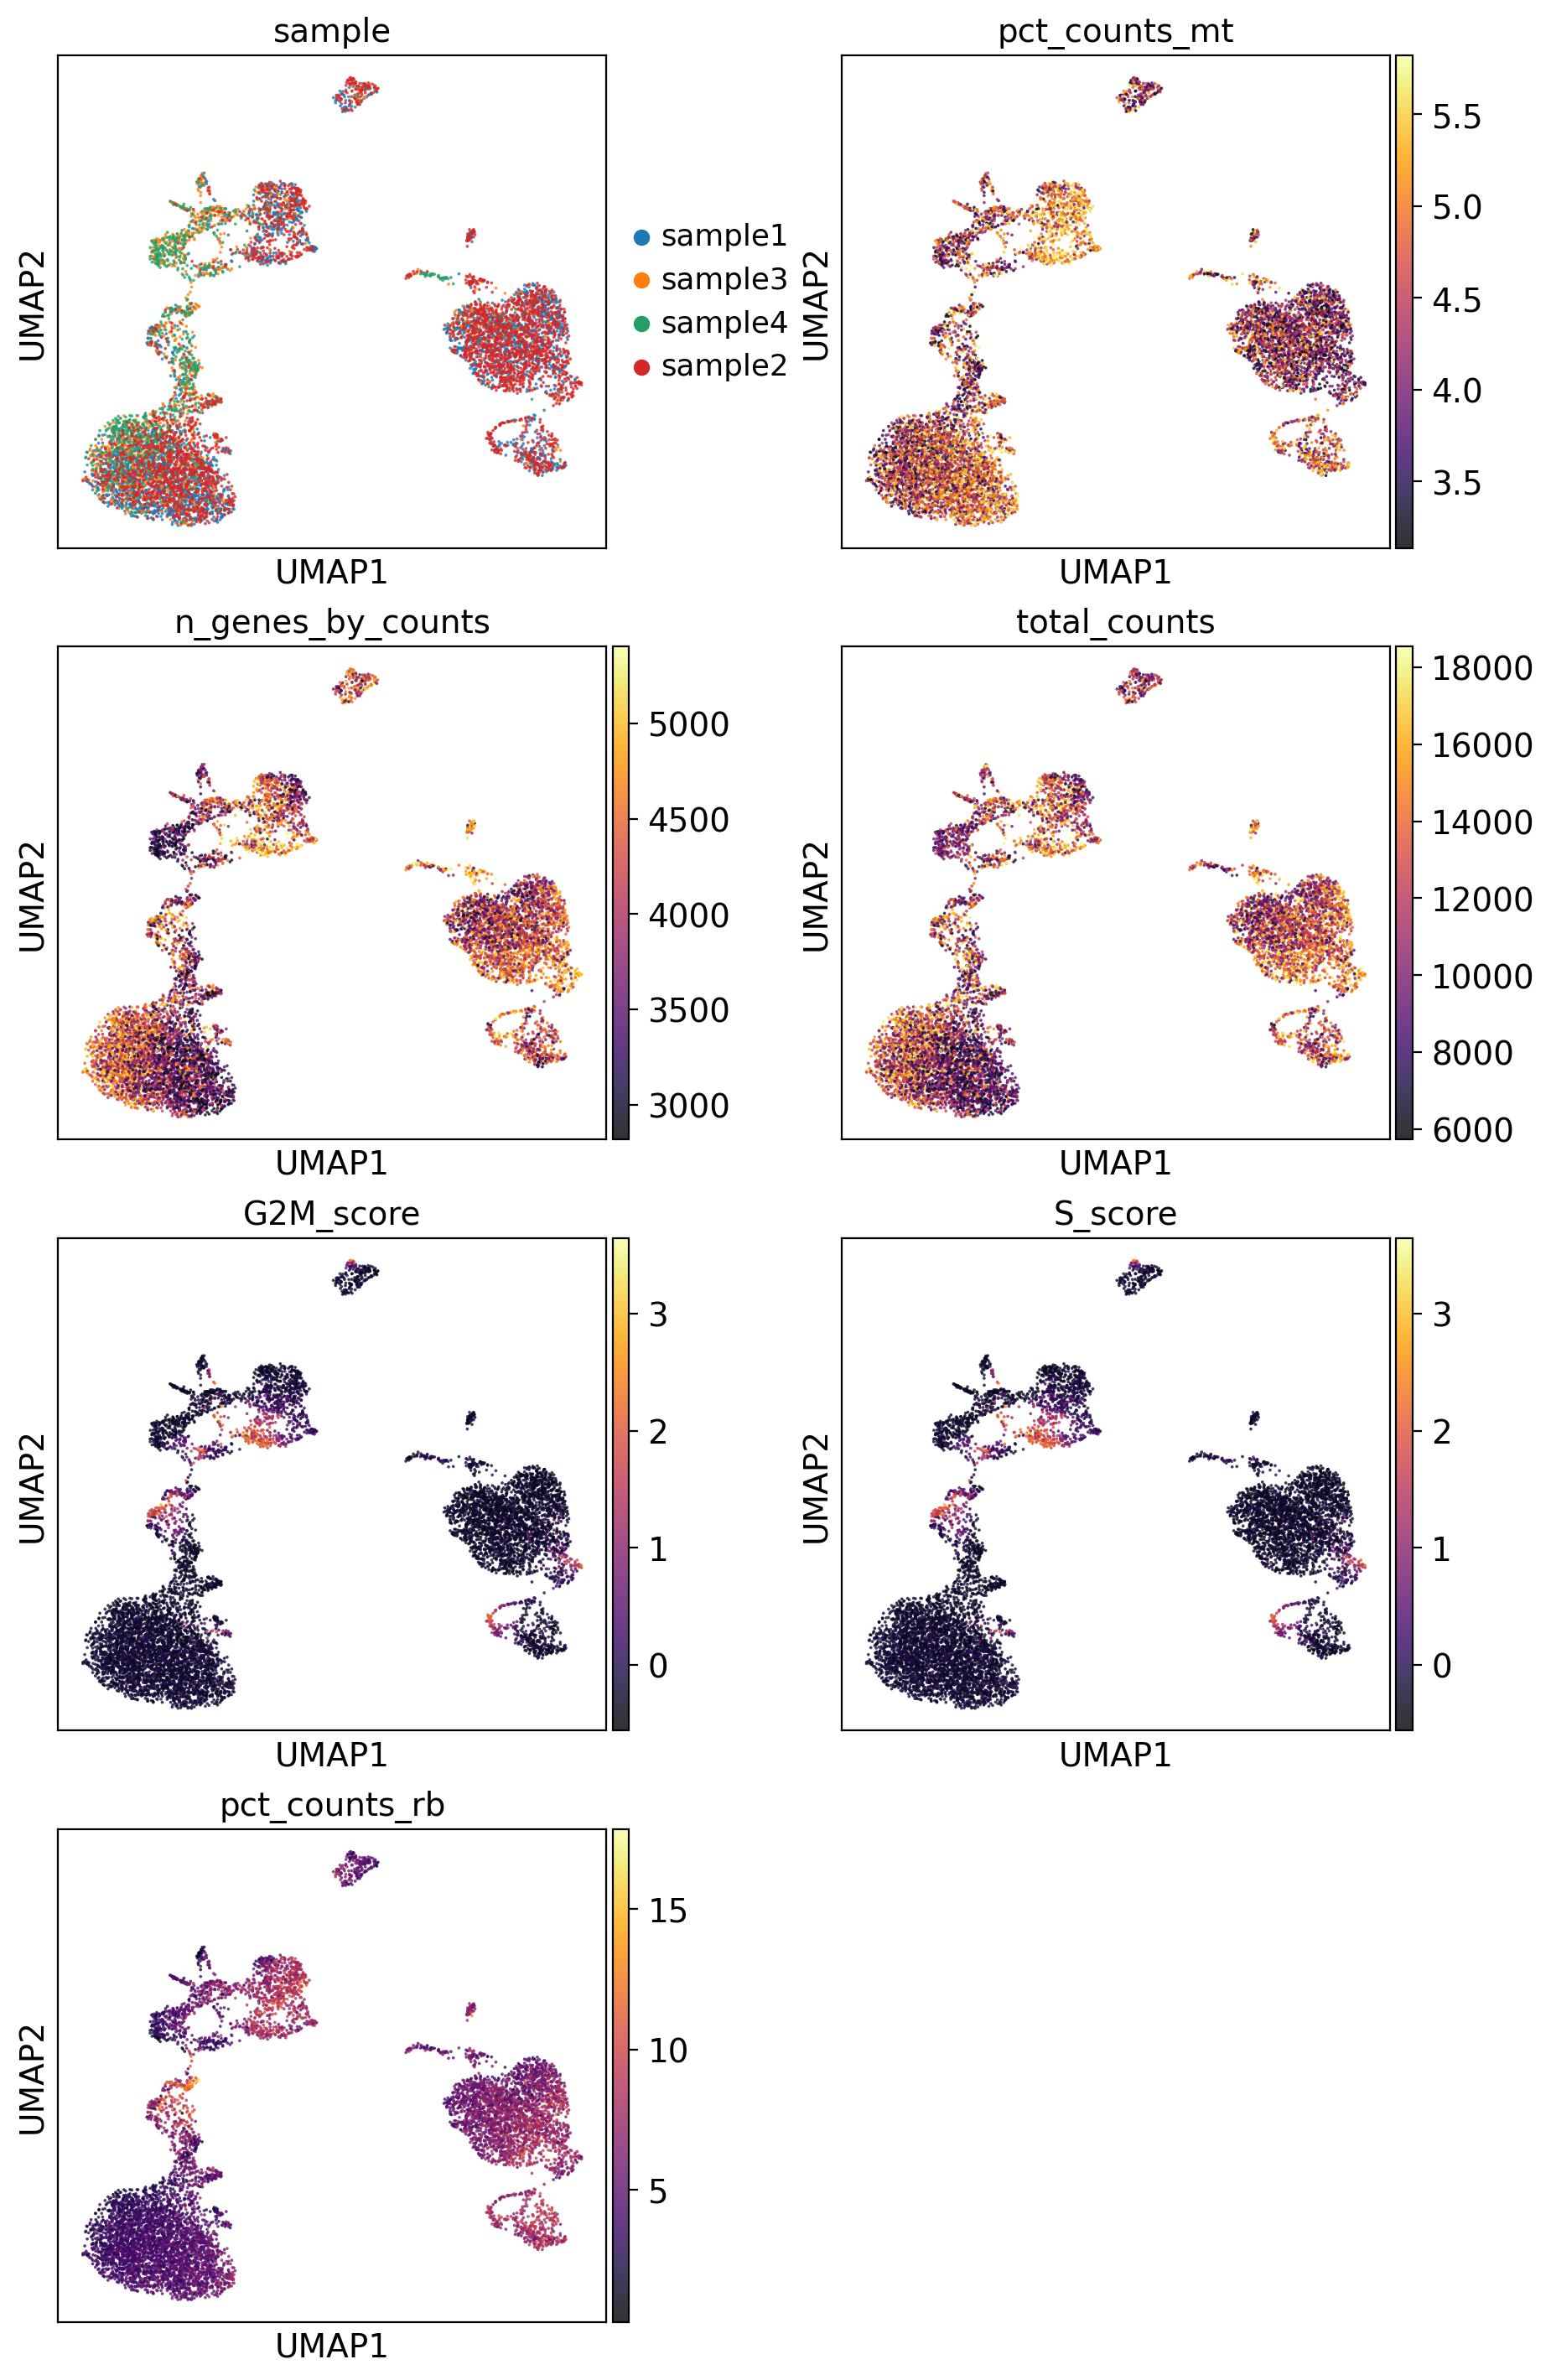

In [187]:
#| echo: false 
#| warning: false

figs = sc.pl.umap(adata, size= 7, color= ["sample"]+keys, show=False, ncols = 2, color_map="inferno", sort_order=False, alpha = 0.8,  hspace=0.2, wspace=0.3)


# Filtering 

## Filtering thresholds

In [175]:
#| echo: false 
#| warning: false

# Wrong Impelementation
# TODO: FIX based on QC_Dict

ls = {}
for key in prior_keys:
    ls[key] = [adata.obs[key][adata.obs[f"{key}_outlier"] == False].agg("min"), adata.obs[key][adata.obs[f"{key}_outlier"] == False].agg("max")]

itables.show(pd.DataFrame(ls, index= ["min", "max"]).T)


## Number of outliers based on provided criteria

In [176]:
#| echo: false 
#| warning: false

#TODO: Fix
df_l = []
col_l = []
for key in prior_keys:
    try:
        df_l.append(pd.DataFrame(adata.obs[[f"{key}_outlier", "sample"]].value_counts().loc[(True), :]))
        col_l.append(f"{key}_outlier")
    except:
        pass


col_l.append(f"aggregate outliers")
df_l.append(pd.DataFrame(adata.obs[[f"outlier", "sample"]].value_counts().loc[(True), :]))


df_l.append(pd.DataFrame(adata.obs[["sample"]].value_counts()))
df_l[-1].index =  df_l[-1].index.get_level_values(0)
col_l.append(f"Total Cells")

df = pd.concat(df_l, axis=1)
df.columns = [col_l]
itables.show(df.fillna(0))


## Cell filtering based on outlier function

In [177]:
#| echo: false 
#| output: false
#| warning: false

# Saving The object at the last step before subsseting
if path.exists(DIR_SAVE):
    adata.write_h5ad(path.join(DIR_SAVE, "raw_adata.h5ad"))
else:
    mkdir(DIR_SAVE)
    adata.write_h5ad(path.join(DIR_SAVE, "raw_adata.h5ad"))

# Cell Filtering based on threshold
adata = adata[(~adata.obs.outlier)].copy()

In [178]:
#| echo: false 
#| warning: false


df1 = adata.obs.groupby("sample")[keys].agg(["mean", "median"]).round(3)
df2 = adata.obs.groupby("sample")[["sample"]].agg(["size"])
pd.concat([df1, df2], axis =1)

pct_counts_mt        n_genes_by_counts          total_counts           \
                 mean median              mean  median          mean   median   
sample                                                                          
sample1         4.459  4.435          4192.860  4224.0  12473.240234  12458.0   
sample3         4.381  4.330          4206.357  4325.5  13419.696289  13833.5   
sample4         4.347  4.298          4188.823  4280.0  13368.076172  13752.0   
sample2         4.511  4.507          3865.571  3784.5  10924.521484  10420.5   

        G2M_score        S_score        pct_counts_rb        sample  
             mean median    mean median          mean median   size  
sample                                                               
sample1    -0.096 -0.215  -0.096 -0.215         5.989  5.682   3203  
sample3    -0.091 -0.212  -0.091 -0.212         5.331  4.847   1270  
sample4    -0.067 -0.196  -0.067 -0.196         4.522  4.107   1093  
sample2    -0.065 -0.206  -0.065 -0.206         6.028  5.924   3296

## Scatter plots of confounders after filtering

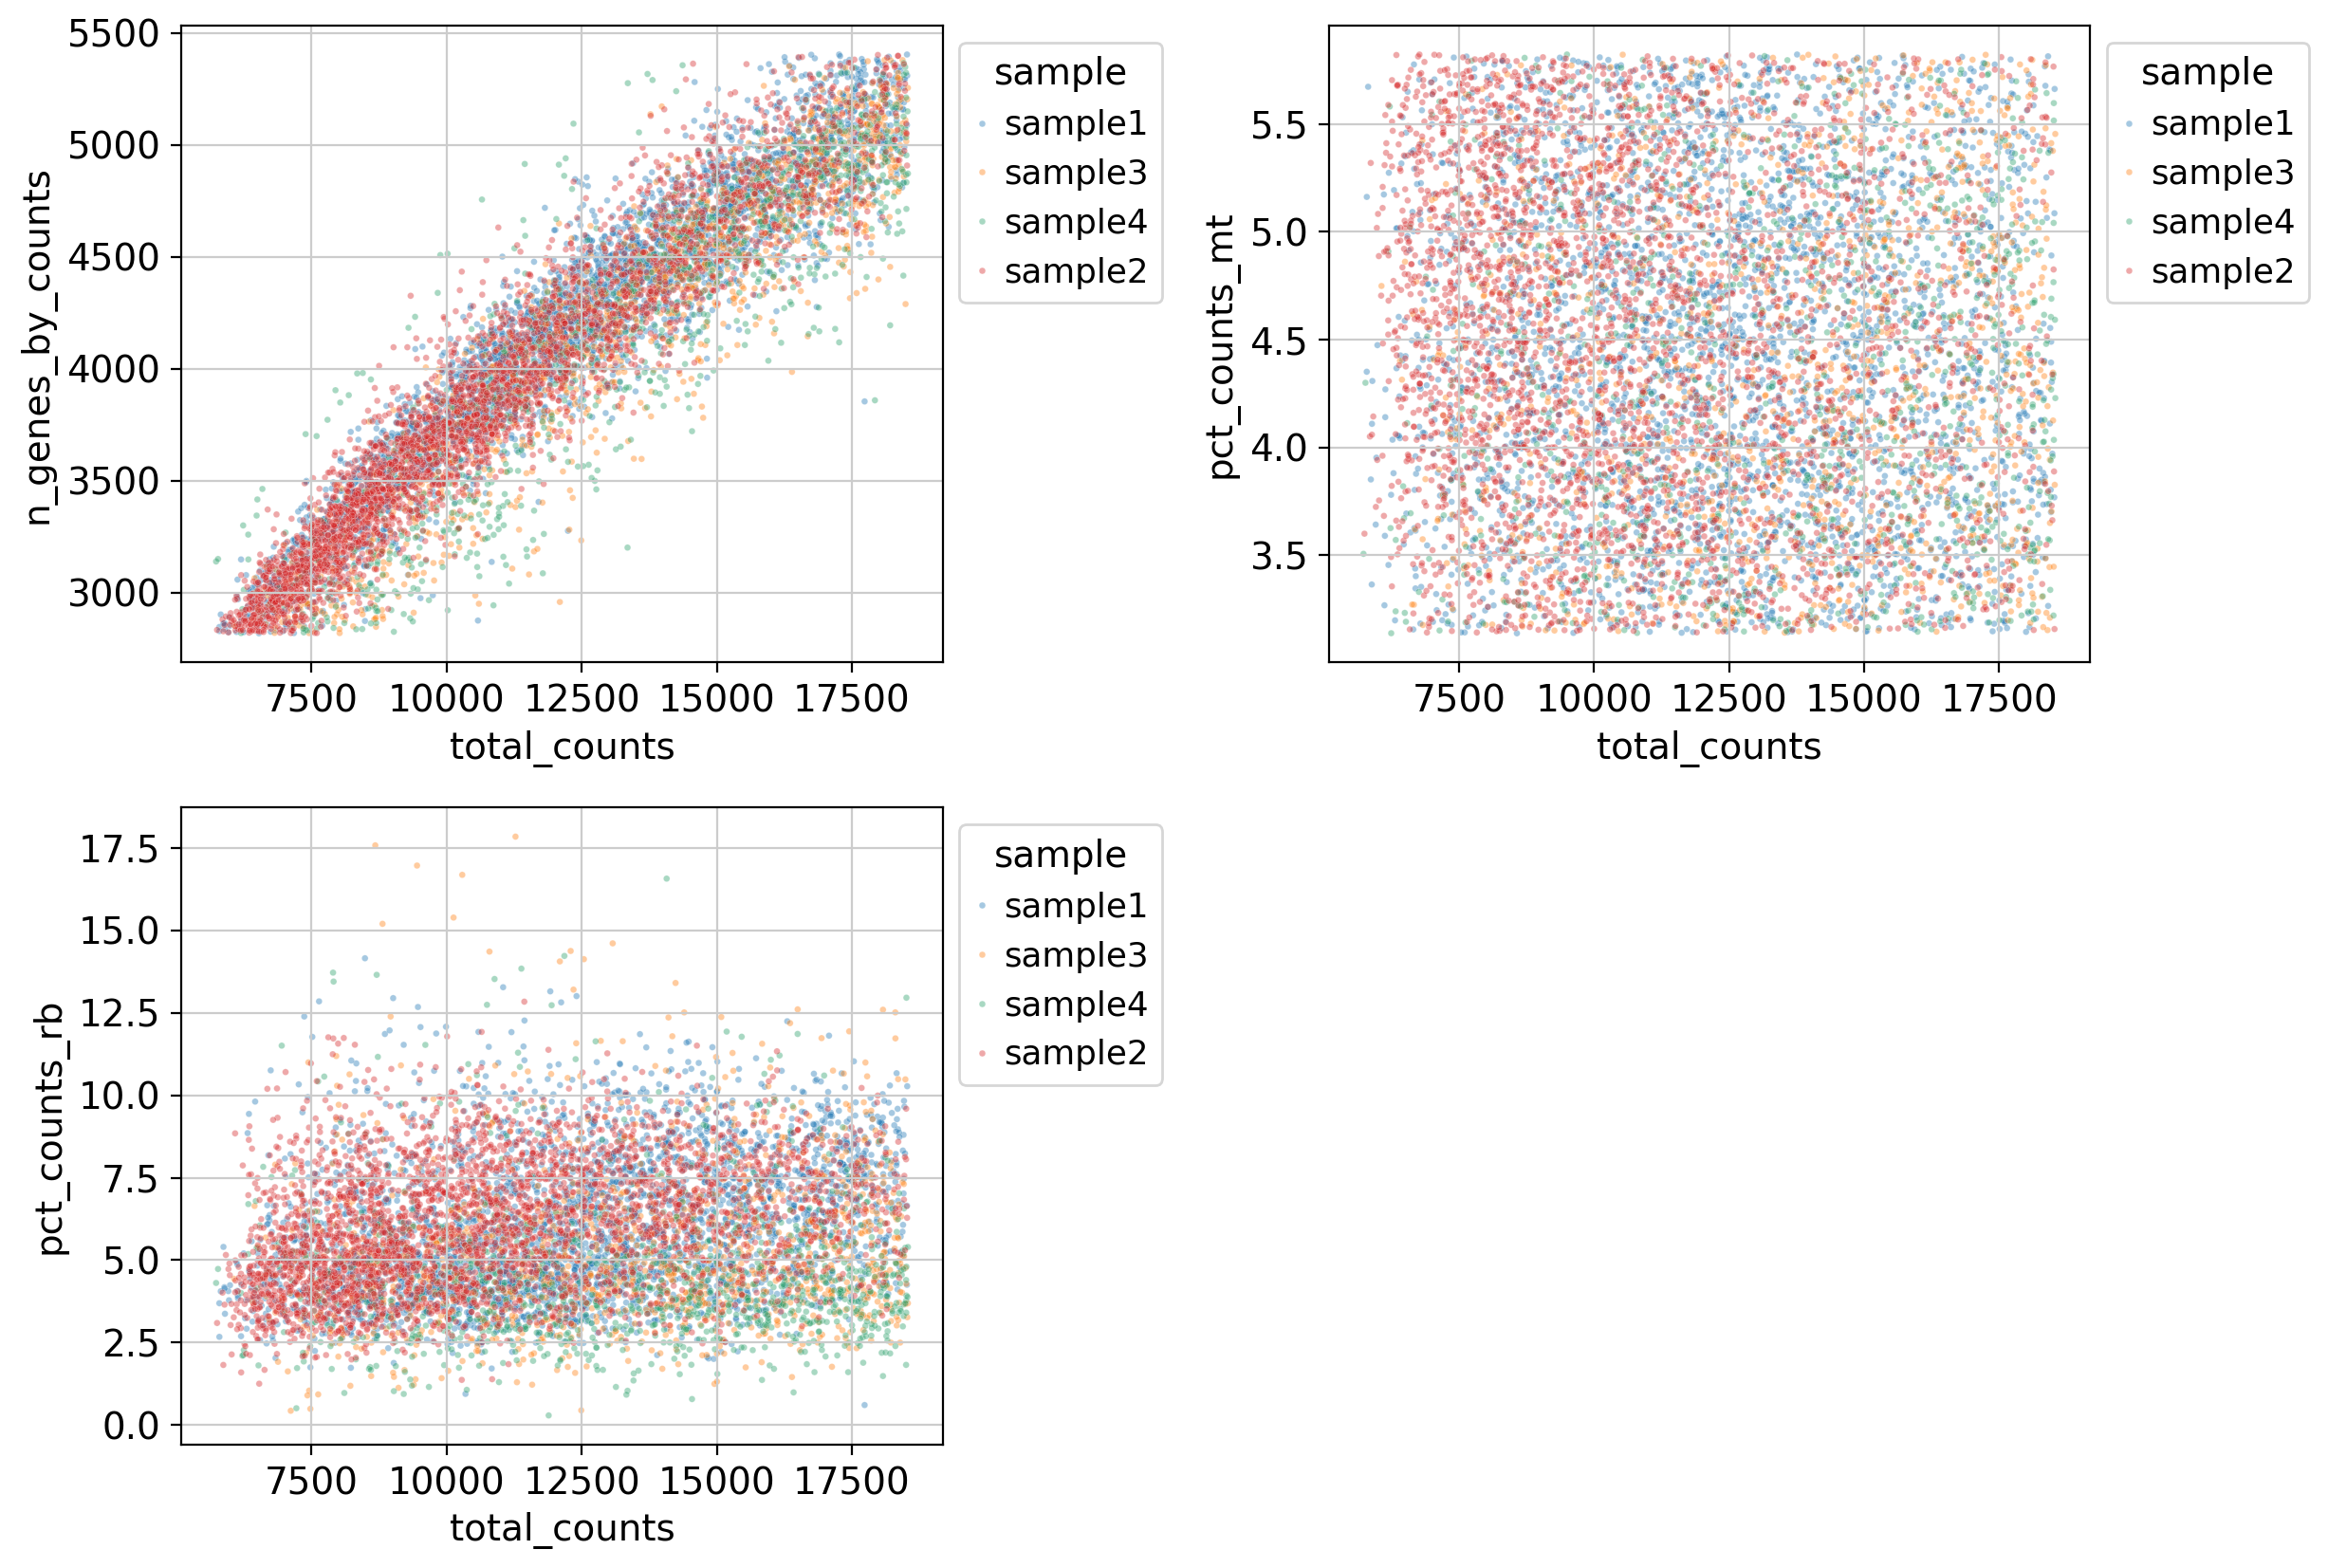

In [179]:
#| echo: false 
#| warning: false

# Assuming 'df' is your DataFrame
df = adata.obs[keys+["sample"]]

# Determine the number of rows and columns for your subplot grid
n = len(df.columns)
ncols = 2
nrows = 2
figwidth= 5
figheight = 4

# Create the subplots
wspace = 0.5
fig, axs = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(ncols * figwidth + figwidth * wspace * (ncols - 1), nrows * figheight + wspace * (nrows - 1) ),
)

plt.subplots_adjust(wspace=wspace, hspace=wspace)

# Flatten the axes
axs = axs.flatten()

sns.scatterplot(df, x="total_counts", y="n_genes_by_counts", hue = "sample", alpha = 0.4, s = 6,  ax= axs[0])
sns.scatterplot(df, x="total_counts", y="pct_counts_mt", hue = "sample", alpha = 0.4, s = 6,  ax= axs[1])
sns.scatterplot(df, x="total_counts", y="pct_counts_rb", hue = "sample", alpha = 0.4, s = 6,  ax= axs[2])
sns.move_legend(axs[0], "upper left", bbox_to_anchor=(1, 1))
sns.move_legend(axs[1], "upper left", bbox_to_anchor=(1, 1))
sns.move_legend(axs[2], "upper left", bbox_to_anchor=(1, 1))

if FILTER_DOUBLETS:
    sns.scatterplot(df, x="total_counts", y="doublet_score", hue = "sample", alpha = 0.4, s = 6,  ax= axs[3])

[fig.delaxes(ax) for ax in axs.flatten() if not ax.has_data()]


plt.tight_layout()
plt.show()


## DecontX contamination

In [180]:
#| echo: false 
#| warning: false

if CORRECT_AMBIENT_RNA and TECHNOLOGY == "10x":
    ax1 = pw.Brick(figsize=(6,6))
    ax2 = pw.Brick(figsize=(6,6))

    scatter = sns.scatterplot(pd.concat([adata.obsm["decontX_UMAP"], adata.obs], axis = 1), x = "DecontX_UMAP_1", y = "DecontX_UMAP_2", hue= "decontX_contamination" , s= 0.8, ax = ax1, palette="inferno")
    sns.move_legend(scatter, "center right", bbox_to_anchor=(1.1, 0.5), title=None, frameon=False)

    scatter = sns.scatterplot(pd.concat([adata.obsm["decontX_UMAP"], adata.obs], axis = 1), x = "DecontX_UMAP_1", y = "DecontX_UMAP_2", hue= "decontX_clusters" , s= 0.8, ax=ax2)
    sns.move_legend(scatter, "center right", bbox_to_anchor=(1.15, 0.5), title=None, frameon=False)

    ax12 = ax1+ax2
    display(ax12)

## Clustering after to cell filtering

In [181]:
#| echo: false 
#| output: false
#| warning: false

sc.pp.pca(adata, n_comps=30)
sc.pp.neighbors(adata)
sc.tl.leiden(adata, key_added="groups", flavor="leidenalg")
sc.tl.umap(adata)

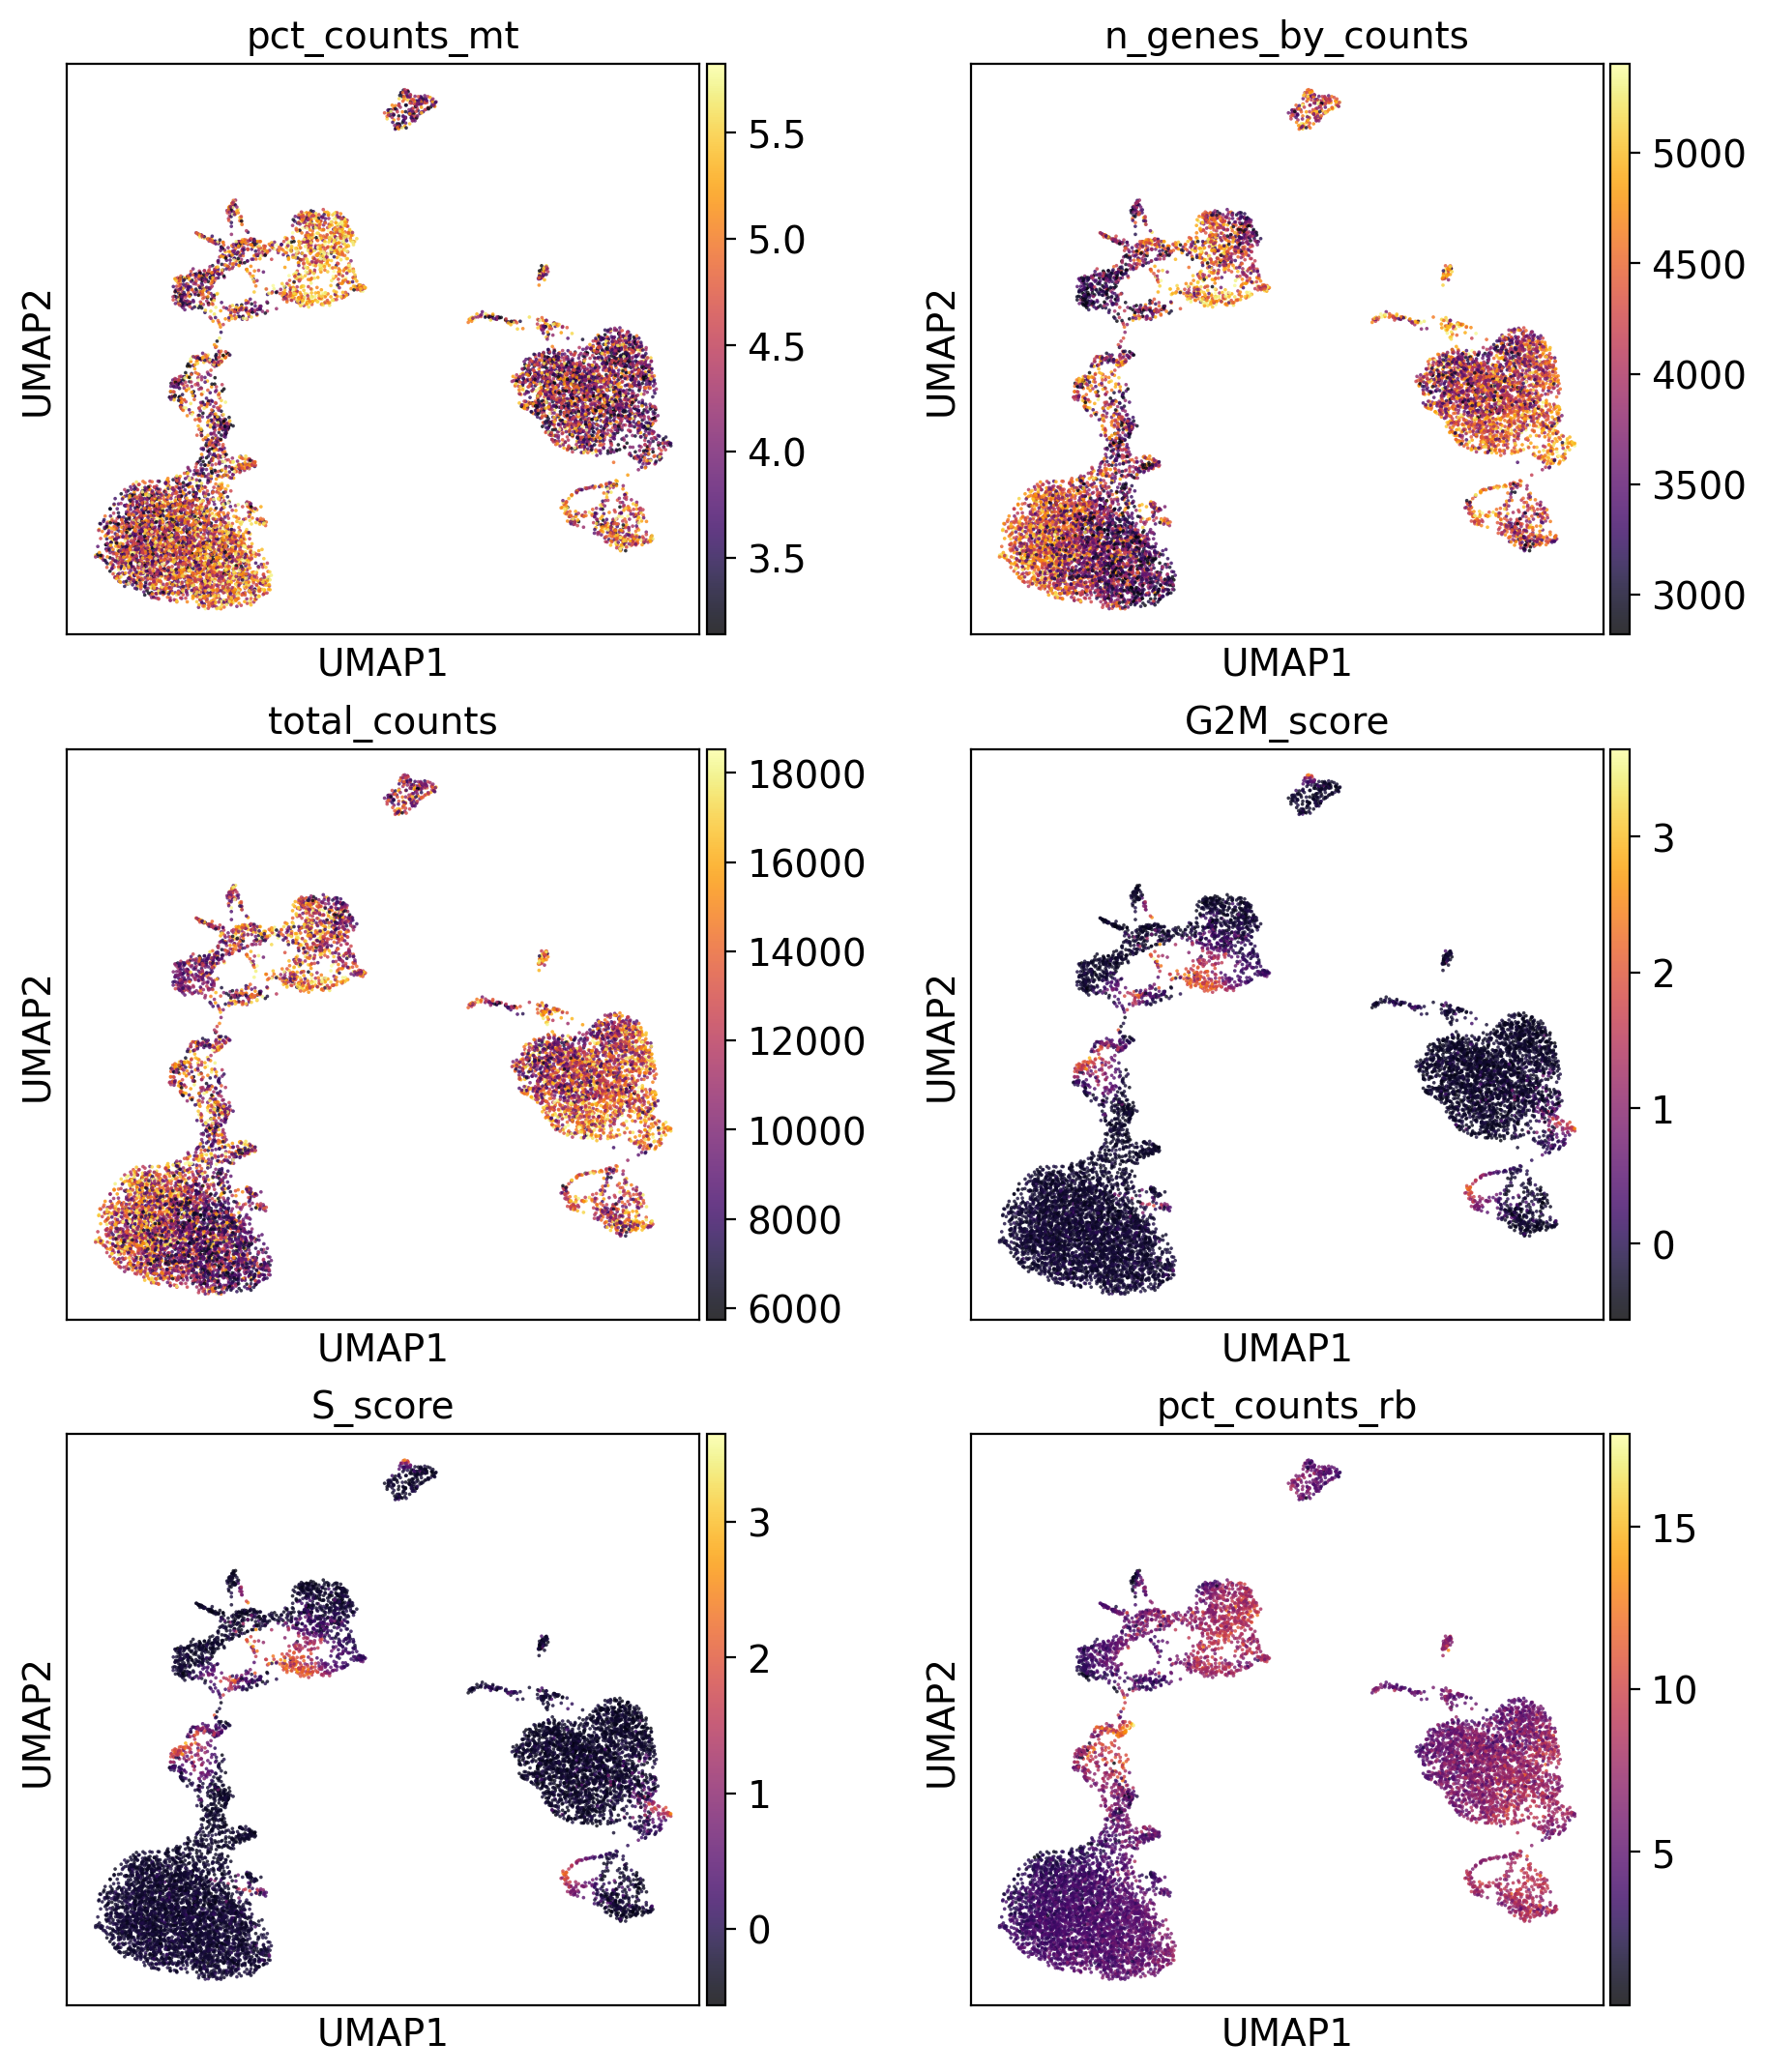

In [182]:
#| echo: false 
#| warning: false

# keys = ["sample", "total_counts", "n_genes_by_counts", "pct_counts_mt"]

# if FILTER_DOUBLETS:
#     keys = keys + ["predicted_doublet"]

# if CELL_CYCLE_SCORE:
#     keys = keys + ["phase"]

figs = sc.pl.umap(adata, size= 7, color= keys, show=False, ncols = 2, color_map="inferno", sort_order=False, alpha = 0.8,  hspace=0.2, wspace=0.3)

# Regression of Variables

In [183]:
#| echo: false 
#| output: false
#| warning: false

# - [ ] Add error handling if the vars to regress is empty or contain non-keys
if REGRESS:
    sc.pp.regress_out(adata, keys= VARS_TO_REGRESS)

# Ambient RNA 

In [184]:
#| echo: false 
#| warning: false

if CORRECT_AMBIENT_RNA:
    sns.violinplot(adata.obs, x = "decontX_clusters", y = "decontX_contamination")
    sns.stripplot(adata.obs, x = "decontX_clusters", y = "decontX_contamination", s = 1, c = "black")

In [185]:
#| echo: false 
#| output: false
#| warning: false

## Save Result
if path.exists(DIR_SAVE):
    adata.write_h5ad(path.join(DIR_SAVE, "adata.h5ad"))
else:
    mkdir(DIR_SAVE)
    adata.write_h5ad(path.join(DIR_SAVE, "adata.h5ad"))

# Session Information

In [186]:
session_info.show()